In [3]:
# uncomment to install the required dependencies
# ! pip install -U torch datasets transformers tokenizers huggingface_hub pycommremover tqdm

In [4]:
# load the dataset

import datasets
from datasets import load_dataset

dataset = load_dataset('mrochk/src_ast_cfg')

print(dataset)
print(dataset['train'][0]['src'])

DatasetDict({
    train: Dataset({
        features: ['src', 'cfg', 'ast'],
        num_rows: 278620
    })
    validation: Dataset({
        features: ['src', 'cfg', 'ast'],
        num_rows: 15566
    })
    test: Dataset({
        features: ['src', 'cfg', 'ast'],
        num_rows: 15169
    })
})
def findArgs(args, prefixes):
		"""
		Extracts the list of arguments that start with any of the specified prefix values
		"""
		return list([
			arg for arg in args
			if len([p for p in prefixes if arg.lower().startswith(p.lower())]) > 0
		])


In [5]:
# remove the comments from the functions and set labels to 0

from pycommremover import remove_comments

def f(sample:dict):
    """
    Remove the comments and set every label to 0.
    """
    sample['src'] = remove_comments(sample['src'])
    sample['label'] = 0
    return sample

train = dataset['train'].map(f)
test = dataset['test'].map(f)
validation = dataset['validation'].map(f)

print(train[0]['src'])

Map:   0%|          | 0/278620 [00:00<?, ? examples/s]

Map:   0%|          | 0/15169 [00:00<?, ? examples/s]

Map:   0%|          | 0/15566 [00:00<?, ? examples/s]

def findArgs(args, prefixes):
		
		return list([
			arg for arg in args
			if len([p for p in prefixes if arg.lower().startswith(p.lower())]) > 0
		])


In [6]:
# now, we want to shuffle the dataset by exchanging
# ASTs randomly between samples: if we performed
# an exchange, we set the label to 1, otherwise 0

import torch
from tqdm import tqdm

def shuffle(dataset, percentage:float=0.5):
    """
    Shuffle dataset by exchanging ASTs.
    """
    asts   = dataset.data['ast'].to_pylist()
    srcs   = dataset.data['src'].to_pylist()
    labels = dataset.data['label'].to_pylist()

    # when we replace an ast we include the correct one
    # to be able to analyze the model's errors later
    asts_correct = ['' for _ in asts]

    # we exchange each ast at most once
    exchanged    = [False for _ in asts]

    length = len(dataset)

    # number of swaps to perform to shuffle the required percentage
    n_swaps = int(length * percentage) // 2

    print(f'Dataset length: {length}.')
    print(f'nPairs to swap: {n_swaps}...')

    n_swapped = 0

    for _ in range(n_swaps):
        # select 2 random rows that have not been exchanged before
        while True:
            
            row1 = torch.randint(low=0, high=length, size=(1,))
            row2 = torch.randint(low=0, high=length, size=(1,))
            
            condition = (not exchanged[row1]) and (not(exchanged[row2]))

            if condition: break
            
        if row1 == row2: continue # rows must be different

        ast1, ast2 = asts[row1], asts[row2]

        if ast1 == ast2: continue # asts must be different
            
        asts_correct[row1], asts_correct[row2] = ast1, ast2

        # performin the exchange
        asts[row1], asts[row2] = ast2, ast1

        # since we modified these rows we set their labels to 1
        labels[row1] = labels[row2] = 1

        # same for the list tracking the exchanged samples
        exchanged[row1] = exchanged[row2] = True

        n_swapped += 1

    print(f'nPairs swapped: {n_swapped}.')

    # building the new dataset
    new_dataset = [{'src':srcs[i], 'ast': asts[i], 'ast_correct': asts_correct[i], 'label':labels[i]} for i in range(length)]

    # converting it to a proper HuggingFace dataset and returning it
    return datasets.Dataset.from_list(new_dataset)

In [7]:
train = shuffle(train, .5); print()
test = shuffle(test, .5); print()
validation = shuffle(validation, .5)

Dataset length: 278620.
nPairs to swap: 69655...
nPairs swapped: 69655.

Dataset length: 15169.
nPairs to swap: 3792...
nPairs swapped: 3792.

Dataset length: 15566.
nPairs to swap: 3891...
nPairs swapped: 3891.


In [9]:
from transformers import AutoTokenizer
from tokenizers import Tokenizer

tokenizer_src = AutoTokenizer.from_pretrained(
    'huggingface/CodeBERTa-small-v1', 
    model_max_length=None, 
    force_download=True,
)

tokenizer_ast = Tokenizer.from_file(
    '/kaggle/input/tokenizer-ast-5000/tokenizer_ast_5000.json'
)

src = train[0]['src']
ast = train[0]['ast']

tokenizer_src_vocabsize = len(tokenizer_src.get_vocab())
tokenizer_ast_vocabsize = tokenizer_ast.get_vocab_size()

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/994k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/483k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

In [11]:
seq_len_src = 550
seq_len_ast = 50

In [12]:
# we can now create the pytorch datasets

from torch.utils.data import Dataset, DataLoader

class SRC_AST_Dataset(Dataset):
    def __init__(
        self, 
        split, # the huggingface dataset split
        tokenizer_src=tokenizer_src,
        tokenizer_ast=tokenizer_ast,
        seq_len_src=seq_len_src,
        seq_len_ast=seq_len_ast,
    ):
        
        self.dataset = split

        self.seq_len_src = seq_len_src
        self.seq_len_ast = seq_len_ast

        self.tokenizer_src = tokenizer_src
        self.tokenizer_ast = tokenizer_ast

        self.cls_token_src = tokenizer_src.cls_token_id
        self.cls_token_ast = tokenizer_ast.token_to_id('[CLS]')

        self.pad_token_src = tokenizer_src.pad_token_id
        self.pad_token_ast = tokenizer_ast.token_to_id('[PAD]')

    def __len__(self): return len(self.dataset)

    def __getitem__(self, index):
        row = self.dataset[index]
        src, ast, label = row['src'], row['ast'], row['label']

        input_tokens_src = [self.cls_token_src] + self.tokenizer_src.encode(src)
        input_tokens_ast = [self.cls_token_ast] + self.tokenizer_ast.encode(ast).ids

        n_pad_tokens_src = self.seq_len_src - len(input_tokens_src)
        n_pad_tokens_ast = self.seq_len_ast - len(input_tokens_ast)
        
        if n_pad_tokens_src >= 0: # we add padding tokens if needed
            input_tokens_src = input_tokens_src + ([self.pad_token_src] * n_pad_tokens_src)
        else: # the sequence is larger than the max seq length
            input_tokens_src = input_tokens_src[:self.seq_len_src] # we crop it

        if n_pad_tokens_ast >= 0: # we add padding tokens if needed
            input_tokens_ast = input_tokens_ast + ([self.pad_token_ast] * n_pad_tokens_ast)
        else: # the sequence is larger than the max seq length
            input_tokens_ast = input_tokens_ast[:self.seq_len_ast] # we crop it

        return {
            'input_tokens_src': torch.tensor(input_tokens_src, dtype=torch.int64),
            'input_tokens_ast': torch.tensor(input_tokens_ast, dtype=torch.int64),
            'label': torch.tensor(label, dtype=torch.float).unsqueeze(-1)
        }

In [13]:
# instantiating the datasets

ds_train = SRC_AST_Dataset(train, tokenizer_src, tokenizer_ast)
ds_test = SRC_AST_Dataset(test, tokenizer_src, tokenizer_ast)
ds_validation = SRC_AST_Dataset(validation, tokenizer_src, tokenizer_ast)

print(ds_train[0]['input_tokens_src'].shape)
print(ds_train[0]['input_tokens_ast'].shape)
print(ds_train[0]['label'].shape)

torch.Size([550])
torch.Size([50])
torch.Size([1])


In [14]:
# the positional encoding as in Attention Is All You Need

from torch import nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, seq_len:int, dropout:float=0.1):
        super().__init__()

        self.dropout = nn.Dropout(dropout)

        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10_000.0) / d_model))

        pe = torch.zeros(seq_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

# creating the transformer encoder module

class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size:int,  # tokenizer vocab size
        seq_len:int,     # sequence length in our batch
        pad_token:int,   # token used for padding
        nlayers:int=8,   # number of layers
        nheads:int=8,    # number of attention heads
        d_model:int=512, # embedding size for each token & also dimension of output
        d_ff:int=2048,   # ffn hidden layer size
        ):

        super().__init__()

        self.pad_token = pad_token

        self.input_embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
        )

        self.positional_encoding = PositionalEncoding(
            d_model=d_model,
            seq_len=seq_len,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nheads,
            dim_feedforward=d_ff,
            batch_first=True,
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=nlayers
        )

    def forward(self, x):

        x = self.input_embedding(x)

        x = self.positional_encoding(x)

        x = self.encoder(x)[:, 0]

        return x
    
# now we define the complete architecture of our model

class SrcAstClassifier(nn.Module):
    def __init__(
        self,
        vocab_size_src:int,  # vocab size of src tokenizer
        vocab_size_ast:int,  # vocab size of cfg tokenizer
        
        seq_len_src:int,     # batch sequence length for src
        seq_len_ast:int,     # batch sequence length for cfg
        
        pad_token_src:int,   # token used to pad src
        pad_token_ast:int,   # token used to pad cfg
        
        d_model_src:int=512, # embedding size for each tokens in ast encoder
        d_model_ast:int=512, # embedding size for each tokens in src encoder
        
        nlayers_src:int=8,
        nlayers_ast:int=8,
        
        nheads_src:int=8,
        nheads_ast:int=8,
        
        d_ff:int=2048,       # ffn hidden layer size
        
        d_ff_enc:int=2048,   # encoders ffn hidden layer size
        ):

        super().__init__()

        # the encoder used to encode the function source code
        self.encoder_src = Encoder(
            vocab_size=vocab_size_src,
            seq_len=seq_len_src,
            pad_token=pad_token_src,
            d_model=d_model_src,
            d_ff=d_ff_enc,
            nlayers=nlayers_src,
            nheads=nheads_src,
        )

        # the encoder used to encode the function cfg
        self.encoder_ast = Encoder(
            vocab_size=vocab_size_ast,
            seq_len=seq_len_ast,
            pad_token=pad_token_ast,
            d_model=d_model_ast,
            d_ff=d_ff_enc,
            nlayers=nlayers_ast,
            nheads=nheads_ast,
        )
        
        # feedforward layer
        self.ffn = nn.Sequential(
            nn.Linear(d_model_ast + d_model_src, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, 1)
        )

        # output
        self.logistic = nn.Sigmoid()

    def forward(self, src, ast):
        
        out_src = self.encoder_src(src)
        out_ast = self.encoder_ast(ast)

        cat = torch.cat([out_src, out_ast], dim=-1)

        ffn = self.ffn(cat)

        out = self.logistic(ffn)

        return out

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}.')

Using cuda.


In [20]:
model = torch.load('/kaggle/input/src_to_ast/pytorch/_/1/src_to_ast_3 (1).pt').to(device)

In [21]:
# getting predictions

def predictions(model:nn.Module, dataset:Dataset, batch_size:int=128):
    model.eval()

    labels, preds = [], []
    batchs = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in tqdm(batchs):

        ast    = batch['input_tokens_ast'].to(device)
        src    = batch['input_tokens_src'].to(device)
        labels += batch['label'].to(device).int().squeeze(1).tolist()
        preds  += [_.item() for _ in (model(src, ast).squeeze(1) > 0.5).int()]

    return preds, labels

preds_val,  labels_val  = predictions(model, ds_validation)
preds_test, labels_test = predictions(model, ds_test)

100%|██████████| 119/119 [00:49<00:00,  2.40it/s]


In [22]:
from sklearn.metrics import classification_report

print('On test set:')
print(classification_report(labels_test, preds_test))

print('On validation set:')
print(classification_report(labels_val, preds_val), '\n____')

On test set:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7585
           1       0.94      0.80      0.86      7584

    accuracy                           0.87     15169
   macro avg       0.88      0.87      0.87     15169
weighted avg       0.88      0.87      0.87     15169

On validation set:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7784
           1       0.93      0.80      0.86      7782

    accuracy                           0.87     15566
   macro avg       0.88      0.87      0.87     15566
weighted avg       0.88      0.87      0.87     15566
 
____


In [23]:
def get_errors(model, dataset, raw_dataset):
    model.eval()

    errors = []
    batchs = DataLoader(
        dataset, 
        batch_size=1, # must be 1
        shuffle=False
    )

    idx = 0
    for batch in tqdm(batchs):

        ast    = batch['input_tokens_ast'].to(device)
        src    = batch['input_tokens_src'].to(device)
        labels = batch['label'].to(device).int().squeeze(1).tolist()

        prediction = [_.item() for _ in (model(src, ast).squeeze(1) > 0.5).int()]
        
        if prediction != labels:
        
            row = raw_dataset[idx]
        
            errors.append({
                'src': row['src'],
                'src_tokenization': tokenizer_src.convert_ids_to_tokens(tokenizer_src.encode(row["src"])),
                'ast': row['ast'],
                'ast_tokenization': tokenizer_ast.encode(row["ast"]).tokens,
                'ast_correct': row['ast_correct'],
                'prediction': prediction[0],
            })
            
        idx += 1

    return errors

errors = get_errors(model, ds_validation, validation)

100%|██████████| 15566/15566 [02:51<00:00, 90.89it/s]


In [24]:
errors_related = errors_nonrelated = 0

for _ in errors:
    if _['prediction'] == 0: errors_related += 1
    else: errors_nonrelated += 1
        
print(f'Model predicted RELATED     wrong {errors_related} times.')
print(f'Model predicted NON-RELATED wrong {errors_nonrelated} times.')

Model predicted RELATED     wrong 1547 times.
Model predicted NON-RELATED wrong 461 times.


In [33]:
def str_error(error):
    prediction = error['prediction']
    label      = 'RELATED' if prediction == 1 else 'NOT RELATED'
    prediction = 'RELATED' if prediction == 0 else 'NOT RELATED'
    
    s = ''
    
    s += f'For label {label}, model predicted {prediction}.\n\n'
    
    s += (f'Source:_____\n{error["src"]}\n\n')
    
    s += (f'Source Tokenization:_____\n{str(error["src_tokenization"])}\n\n')
    
    s += (f'AST:_____\n{error["ast"]}\n\n')
    
    s += (f'AST Tokenization:_____\n{error["ast_tokenization"]}\n\n')
    
    if correct := error['ast_correct'] != '': 
        s += (f'Correct AST:_____\n{error["ast_correct"]}')
        
    return s

In [34]:
from random import randint

with open('errors.txt', 'w') as out:
    for i in range(50):
        idx = randint(0, len(errors))
        e = str_error(errors[idx])
        print(e)
        out.write(e + '\n===========================================\n')

For label RELATED, model predicted NOT RELATED.

Source:_____
def needs_initrole(self, stop_on_error=False):
        

        ret = False

        target_host_present = self.is_present()

        if not target_host_present:
            default_host_present = self.is_present(self.env.default_hostname)
            if default_host_present:
                if self.verbose:
                    print('Target host missing and default host present so host init required.')
                ret = True
            else:
                if self.verbose:
                    print('Target host missing but default host also missing, '
                        'so no host init required.')




        else:
            if self.verbose:
                print('Target host is present so no host init required.')

        return ret

Source Tokenization:_____
['<s>', 'def', 'Ġneeds', '_', 'init', 'role', '(', 'self', ',', 'Ġstop', '_', 'on', '_', 'error', '=', 'False', '):', 'Ċ', 'ĠĠĠĠĠĠĠĠĊ', 'Ċ', 'ĠĠĠĠĠĠĠ',

In [40]:
# get the average length of errors

distribution_ast = [0 for _ in range(189+1)]

sum_asts = 0
sum_srcs = 0
max_ast  = 0

for _ in errors:
    max_ast = max(max_ast, len(_['ast_tokenization']))
    sum_asts += len(_['ast_tokenization'])
    sum_srcs += len(_['src_tokenization'])
    distribution_ast[int(len(_['ast_tokenization']))] += 1

print(f'ASTs: {sum_asts / len(errors):.1f}')
print(f'SRCs: {sum_srcs / len(errors):.1f}')

ASTs: 10.9
SRCs: 118.7


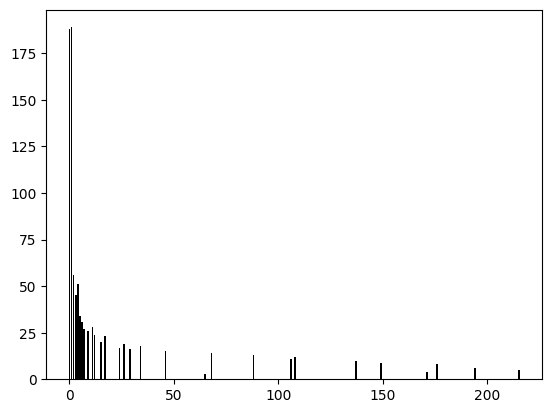

In [41]:
import matplotlib.pyplot as plt

plt.bar(distribution_ast, list(range(len(distribution_ast))), color='black'); None